# Visualising the Hox genes

In [1]:
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs

from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def read_gff(loc):
    gff = pd.read_csv(loc, sep="\t", header=None, skiprows=1)
    gff_columns = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
    gff.columns = gff_columns
    return gff

In [4]:
gff_loc = "~/Documents/data/pycnogonum/hox.gff3"
gff = read_gff(gff_loc)

In [5]:
gff["gene"] = gff["attributes"].str.split("ID=").str[1].str.split(";").str[0].str.split(".").str[0]

In [6]:
def ends(df):
    return df["start"].min(), df["end"].max()

In [7]:
tmp = gff.groupby("gene").apply(ends)
hox = pd.DataFrame(tmp.tolist(), columns=["start", "end"], index=tmp.index)
hox["color"] = ["magenta", "royalblue", "darkmagenta", "goldenrod", "red", "orange", "green", "gold", "darkturquoise"]
hox["name"] = ["Hox1/Lb", "Hox10/AbdB", "Hox2/Pb", "Hox3", "Hox4/Dfd", "Hox5/Scr", "Hox6/Ftz", "Hox7/Antp", "Hox8/Ubx"]
hox["offset"] = [0.02, 0.02, -0.025, 0.02, 0.02, 0.02, -0.025, 0.02, 0.02]

## Manual curation of Hox genes

We have a list of putative Hox CDS for the basic 10 Hox genes (except for Abdominal A, which is
presumed missing in pycnogonids). Align against the flye assembly and manually extract the relevant
high-quality matches, to be plotted here. Also add the miRNA genes, as predicted by MirMachine for
the draft genome:

```
pseudochrom_56	MirMachine	microRNA	2121209	2121272	52.8	+	.	gene_id=Mir-10.PRE;E-value=6.1e-08;
pseudochrom_56	MirMachine	microRNA	2228728	2228791	49.4	-	.	gene_id=Mir-10.PRE;E-value=4.7e-07;
```

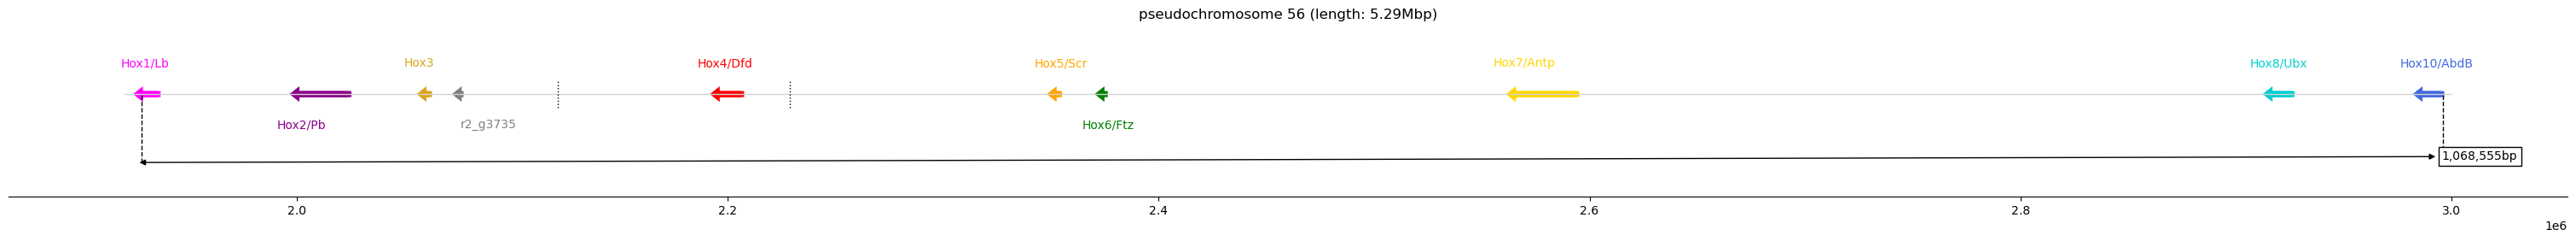

In [8]:
fig, ax = plt.subplots(figsize=(30, 2))
# plot contig
ax.plot([1920000, 3000000], [0, 0], color="lightgray", linewidth=1)

for name, gene in hox.iterrows():
    # ax.plot([gene["start"], gene["end"]], [0, 0], color=mcolors.CSS4_COLORS[gene["color"]], linewidth=10)
    start = gene["start"]
    end = gene["end"]
    ax.arrow(end, 0, start-end-1000, 0, head_width=0.05, head_length=1000, fc=mcolors.CSS4_COLORS[gene["color"]], ec=mcolors.CSS4_COLORS[gene["color"]], linewidth=5)
    ax.text(gene["start"]-10000, gene["offset"]*20, gene["name"], color=mcolors.CSS4_COLORS[gene["color"]], fontsize=10)

ax.vlines(2121209, -0.2, 0.2, color="black", linewidth=1, linestyle="dotted")
ax.vlines(2228728, -0.2, 0.2, color="black", linewidth=1, linestyle="dotted")


# ax.plot([2075916, 2076806], [0, 0], color="gray", linewidth=10)
ax.arrow(2075916, 0, 2075916-2076806, 0, head_width=0.05, head_length=1000, fc="gray", ec="gray", linewidth=5)
ax.text(2075916, -0.025*20, 'r2_g3735', color="gray", fontsize=10)

ax.vlines(1927670, -1, 0, color="k", linewidth=1, linestyle="--")
ax.vlines(2996225, -1, 0, color="k", linewidth=1, linestyle="--")

ax.annotate('1,068,555bp', xy=(1925670, -1), xytext=(3013225, -1), xycoords='data',
            fontsize=10, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', color='k'),
            arrowprops=dict(arrowstyle='<|-|>', lw=1.0, color='k'))

# now add miRNAs

ax.set_yticks([])
ax.set_ylim(-1.5, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title(f"pseudochromosome 56 (length: 5.29Mbp)");
plt.gca().set_position([0, 0, 1, 1])
plt.savefig("figs/hox.svg", bbox_inches='tight', pad_inches=0)

1068555bp long

These loci correspond to following gene models:

- Hox1: PB.8615
- Hox2: g9718
- Hox3: PB.8616
- Hox4: g9720
- Hox5: g9721
- Hox6: PB.8617
- Hox7: g9723
- Hox8: g9724
- Hox9: (missing)
- Hox10: g9725


# Comparison to other chelicerates/arthropods

We compiled a list of Hox genes and compare all of them in a single phylogenetic tree. This
contains:

- The Hox sequences from [Kulkarni _et al._ (2024)](https://doi.org/10.1093/jhered/esae074) from the
  _Mastigoproctus giganteus_ genome manuscript. These sequences are based on the [Aase-Remedios _et
  al._ (2023)](https://doi.org/10.1093/molbev/msad239) analysis of the spider Homeobox gene
  repertoire, but add the vinegaroon _Mastigoproctus_ and the harvestman _Odiellus spinosus_.
- The "canonical" Hox genes of the _P. litorale_ genome as described above.
- The pycnogonid Hox genome complement, as described in various transcriptomic studies and reported
  by [Ballesteros _et al._ (2021)](https://doi.org/10.1093/molbev/msaa228).
- a list of putative abdA candidate transcripts from the various developmental transcriptomes of _P.
  litorale_, as described in this study (for details see the [relevant
  notebook](./abdA_txomes.ipynb)).
- The _Drosophila_ homeobox (but non-Hox) genes _msh_, _en_, and _vnd_ (NK-2), to be used as
  outgroups.

First we will concatenate all the sequences and align them using MAFFT, then build a phylogenetic
tree using IQ-TREE.

First, quick-and-dirty alignment so we can just cut out the homeodomain regions:

```bash
> cd /lisc/scratch/zoology/pycnogonum/genome/draft/hox
> mafft --thread 4 hox.fa > hox_aligned.fasta
```

Now we can extract the homeodomain regions. This was done manually in Jalview, by deleting columns
left and right of the homeobox region. The exact bounds were determined by giving preference to the
Aase-Remedio sequences. The resulting trimmed alignment was saved as `homeobox.fasta` and re-aligned
with MAFFT in L-INS-i mode (Probably most accurate, very slow):

```bash
> /usr/bin/time mafft --thread 4 --maxiterate 1000 --localpair homeobox.fasta > homeobox_aligned.fasta
```

After removing a couple of duplicate sequences that somehow slipped through, we used IQTREE2 to
calculate the phylogenetic tree:

```bash
> module load iqtree
> iqtree2 -s ./homeobox_aligned.fasta -B 1000
```
